In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import sys
sys.path.append('../code')
sys.path.append('../FINAL')

# Load custom functions
from interpolation import cfl_interpolation5
from diusst_funcs import make_mesh
from diusst_model5 import diusst_bayesian as diusst
from diusst_eulerc import diusst_eulerc
from diusst_funcs import *

In [3]:
# DIUSST model
k0 = 0.8
lambd = 3
z_f = 10
dz0 = 0.10
ngrid = 40
diffu = 1
opac = 1
k_mol = 1e-7
maxwind = 10
ref_level = int(21)

data_path = '../data/bayesian_training/'
data_filename = 'training_minnett_err-boatspd-x2_humid10.csv'
data_interval1 = [96,413]
data_interval2 = [1290,1585]#[0,-1]#
removeidx2 = [69,74,81,82,99,100,171,172,176]#[]

In [18]:
# Load dataset
data_orig = pd.read_csv(data_path+data_filename)[786:]

data_orig1 = pd.read_csv(data_path+data_filename)[data_interval1[0]:data_interval1[1]]

data_orig2_dirty = pd.read_csv(data_path+data_filename)[data_interval2[0]:data_interval2[1]]
data_orig2 = data_orig2_dirty.drop(data_orig2_dirty.index[removeidx2])

In [19]:
# extract data from dataset 
ftemp = np.mean(data_orig['ftemp'].to_numpy(np.float64))
times_orig = data_orig['times'].to_numpy(np.float64)
sst_data = data_orig['sst'].to_numpy(np.float64) - data_orig['ftemp'].to_numpy(np.float64)
sst_err = data_orig['sst_err'].to_numpy(np.float64)

## insert param vals here

In [20]:
kappa, mu, attenu = [7.391954640890024e-05, 0.0035497250908049435, 2.314444021159577]

In [21]:
# interpolate to meet CFL condition
data1, dtlist1, idx1 = cfl_interpolation5(data_orig, dz0=dz0, ngrid=ngrid,
        k_mol = k_mol,
        k_eddy_max=kappa, k_0_min=k0, lambd_min=lambd,
        maxwind=maxwind, z_f=z_f,
        save=None,verbose=False)


times1 = data1['times'].to_numpy(np.float64)
wind1 = data1['wind'].to_numpy(np.float64)
swrad1 = data1['swrad'].to_numpy(np.float64)
humid1 = data1['humid'].to_numpy(np.float64)
atemp_rel1 = data1['atemp'].to_numpy(np.float64) - data1['ftemp'].to_numpy(np.float64) + ftemp

In [22]:
params = [kappa,mu,attenu]
sim= diusst_eulerc(times1,atemp_rel1,swrad1,u_data=wind1,sa_data=humid1,T_f=ftemp,dz=dz0,attenu=attenu,mu=mu,k_eddy=kappa,k0=k0,gamma=lambd,
             ngrid=ngrid)

In [23]:
def slab(times, Ta_data, u, swrad, s_a, d=1, sink=100, Tf=300):
    
    T = np.ones(len(times))*Tf
    dt = times[1:]-times[:-1]
    
    n_w = 1.34                     # refractive index of sea water
    n_a = 1.0                     # refractive index of air
    rho_w = 1027                   # density of sea water (in kg/m^3)
    rho_a = 1.1                    # density of air (in kg/m^3)
    C_s = 1.3e-3                   # turbulent exchange coefficient for sensible heat
    C_l = 1.5e-3                   # turbulent exchange coefficient for latent heat
    L_evap = 2.5e6                 # latent heat of evaporization (J/kg) Source: Klose p.151
    c_p = 3850                     # specific heat of sea water at const pressure (in J/K/kg)
    c_p_a = 1005                   # specific heat of air at const pressure (in J/K/kg)
    sb_const = 5.67e-8             # Stefan Boltzmann constant (in W/m^2/K^4)
    R_v = 461.51     
    opac=1
    
    for n in range(1,len(times)):
        #print(u[n-1])
        R_lw = sb_const * (opac*(Ta_data[n-1])**4 - (T[n-1])**4)
        Q_s  = rho_a * c_p_a * C_s * max(0.5, u[n-1]) * (Ta_data[n-1] - T[n-1])
        Q_l  = rho_a * L_evap * C_l * max(0.5, u[n-1]) * (s_a[n-1] - s_sat(T[n-1], rho_a, R_v))
        
        dT = dt[n-1]/(rho_w*c_p*d)*(swrad[n]+R_lw+Q_s+Q_l-sink)
        
        T[n] = T[n-1]+dT
    
    return T

In [60]:
slabsim = slab(times1,atemp_rel1,wind1,swrad1,humid1,Tf=ftemp,sink=50,d=1)

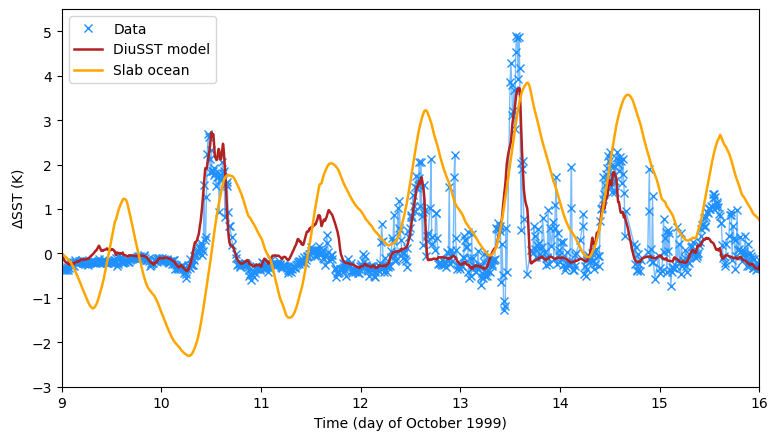

In [62]:
fig, ax = plt.subplots(dpi=100,figsize=(9,5))
ax.plot(times_orig/86400,sst_data,lw=1,c='dodgerblue',alpha=.6)
ax.plot(times_orig/86400,sst_data,'x',markersize=6,c='dodgerblue',label='Data')
ax.plot(times1/86400,sim[0][:,0]-sim[0][:,21],c='firebrick',label='DiuSST model',lw=1.8)
ax.plot(times1/86400,slabsim-ftemp,c='orange',label='Slab ocean',lw=1.8)

ax.set(xlim=(8,15),ylim=(-3,5.5),xticks=np.arange(8,16),xticklabels=np.arange(9,17))
ax.legend(loc='upper left')
ax.set(xlabel='Time (day of October 1999)',ylabel='$\Delta$SST (K)')

#plt.savefig('../../Masterarbeit/thesis/figs/diusst-v-slab.pdf')

In [57]:
np.where(times_orig/86400>=8)[0][0]

0